In [20]:
from msclap import CLAP
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd
import os

In [17]:
babble_noise_filepath = "/bucket/data_collection/datasets/purchased_data/source/zapsplat_p1_babble_2023/annotation_results/meta_1.csv"

df= pd.read_csv(babble_noise_filepath)

noise_df = df.loc[df['main_type'] == 'noise']
noise_df['sub_type'].unique()

noise_df = df.loc[noise_df['sub_type'] == 'noise']

# print(noise_df['filepath'][0])
# print(noise_df['srcFilename'][0])

array(['clapping/hands', 'other', 'engine', 'vehicle',
       'indoor non-intelligible noise', 'liquid/water',
       'outdoor non-intelligible noise', 'laughing',
       'fan/air conditioning', 'silence', 'group babble',
       'instrumental music', 'weather', 'generic impact sounds',
       'mechanisms/tools', 'domestic animals/pets', 'wild animals',
       'bell', 'alarm/siren/horn', 'group cheering', 'human (non-speech)'],
      dtype=object)

In [19]:
noise_df_clean = noise_df[['filepath', 'sub_type']]
display(noise_df_clean)
classes = noise_df_clean['sub_type'].unique()

class_id_map = {name: i for i, name in enumerate(classes, 0)}
print(class_id_map)

prompt = 'this is the sound of '
y = [prompt + x for x in classes]
print(y)

,filepath,sub_type
0,/bucket/data_collection/datasets/purchased_dat...,clapping/hands
1,/bucket/data_collection/datasets/purchased_dat...,clapping/hands
2,/bucket/data_collection/datasets/purchased_dat...,clapping/hands
3,/bucket/data_collection/datasets/purchased_dat...,clapping/hands
5,/bucket/data_collection/datasets/purchased_dat...,other
...,...,...
1934,/bucket/data_collection/datasets/purchased_dat...,vehicle
1935,/bucket/data_collection/datasets/purchased_dat...,vehicle
1936,/bucket/data_collection/datasets/purchased_dat...,vehicle
1937,/bucket/data_collection/datasets/purchased_dat...,vehicle


{'clapping/hands': 0, 'other': 1, 'engine': 2, 'vehicle': 3, 'indoor non-intelligible noise': 4, 'liquid/water': 5, 'outdoor non-intelligible noise': 6, 'laughing': 7, 'fan/air conditioning': 8, 'silence': 9, 'group babble': 10, 'instrumental music': 11, 'weather': 12, 'generic impact sounds': 13, 'mechanisms/tools': 14, 'domestic animals/pets': 15, 'wild animals': 16, 'bell': 17, 'alarm/siren/horn': 18, 'group cheering': 19, 'human (non-speech)': 20}
['this is the sound of clapping/hands', 'this is the sound of other', 'this is the sound of engine', 'this is the sound of vehicle', 'this is the sound of indoor non-intelligible noise', 'this is the sound of liquid/water', 'this is the sound of outdoor non-intelligible noise', 'this is the sound of laughing', 'this is the sound of fan/air conditioning', 'this is the sound of silence', 'this is the sound of group babble', 'this is the sound of instrumental music', 'this is the sound of weather', 'this is the sound of generic impact sounds

In [21]:
# Load and initialize CLAP
clap_model = CLAP(version = '2023', use_cuda=True)

# Computing text embeddings
text_embeddings = clap_model.get_text_embeddings(y)

In [24]:
# Computing audio embeddings
y_preds, y_labels = [], []
print(os.getcwd())

for i in tqdm(range(len(noise_df_clean))):
    path, label = noise_df_clean.iloc[i]
    idx = class_id_map[label]
    #print(idx)
    one_hot_target = torch.nn.functional.one_hot(torch.tensor([idx]), num_classes=len(classes)+1)

    audio_embeddings = clap_model.get_audio_embeddings([path], resample=True)
    similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)

    y_pred = F.softmax(similarity.detach().cpu(), dim=1).numpy()

    y_preds.append(y_pred)
    y_labels.append(one_hot_target.detach().cpu().numpy())


/mounts/ud-data/jtaylor/a5f2c23d-7fb6-41a6-ac0c-3a2ffc02b992/data/acoustic_scene_classification/CLAP-main/examples


100%|██████████| 1124/1124 [00:55<00:00, 20.18it/s]


In [25]:
y_labels, y_preds = np.concatenate(y_labels, axis=0), np.concatenate(y_preds, axis=0)
y_label_val = np.argmax(y_labels, axis=1)
y_pred_val = np.argmax(y_preds, axis=1)
acc = accuracy_score(np.argmax(y_labels, axis=1), np.argmax(y_preds, axis=1))
print('ESC50 Accuracy {}'.format(acc))

ESC50 Accuracy 0.23309608540925267


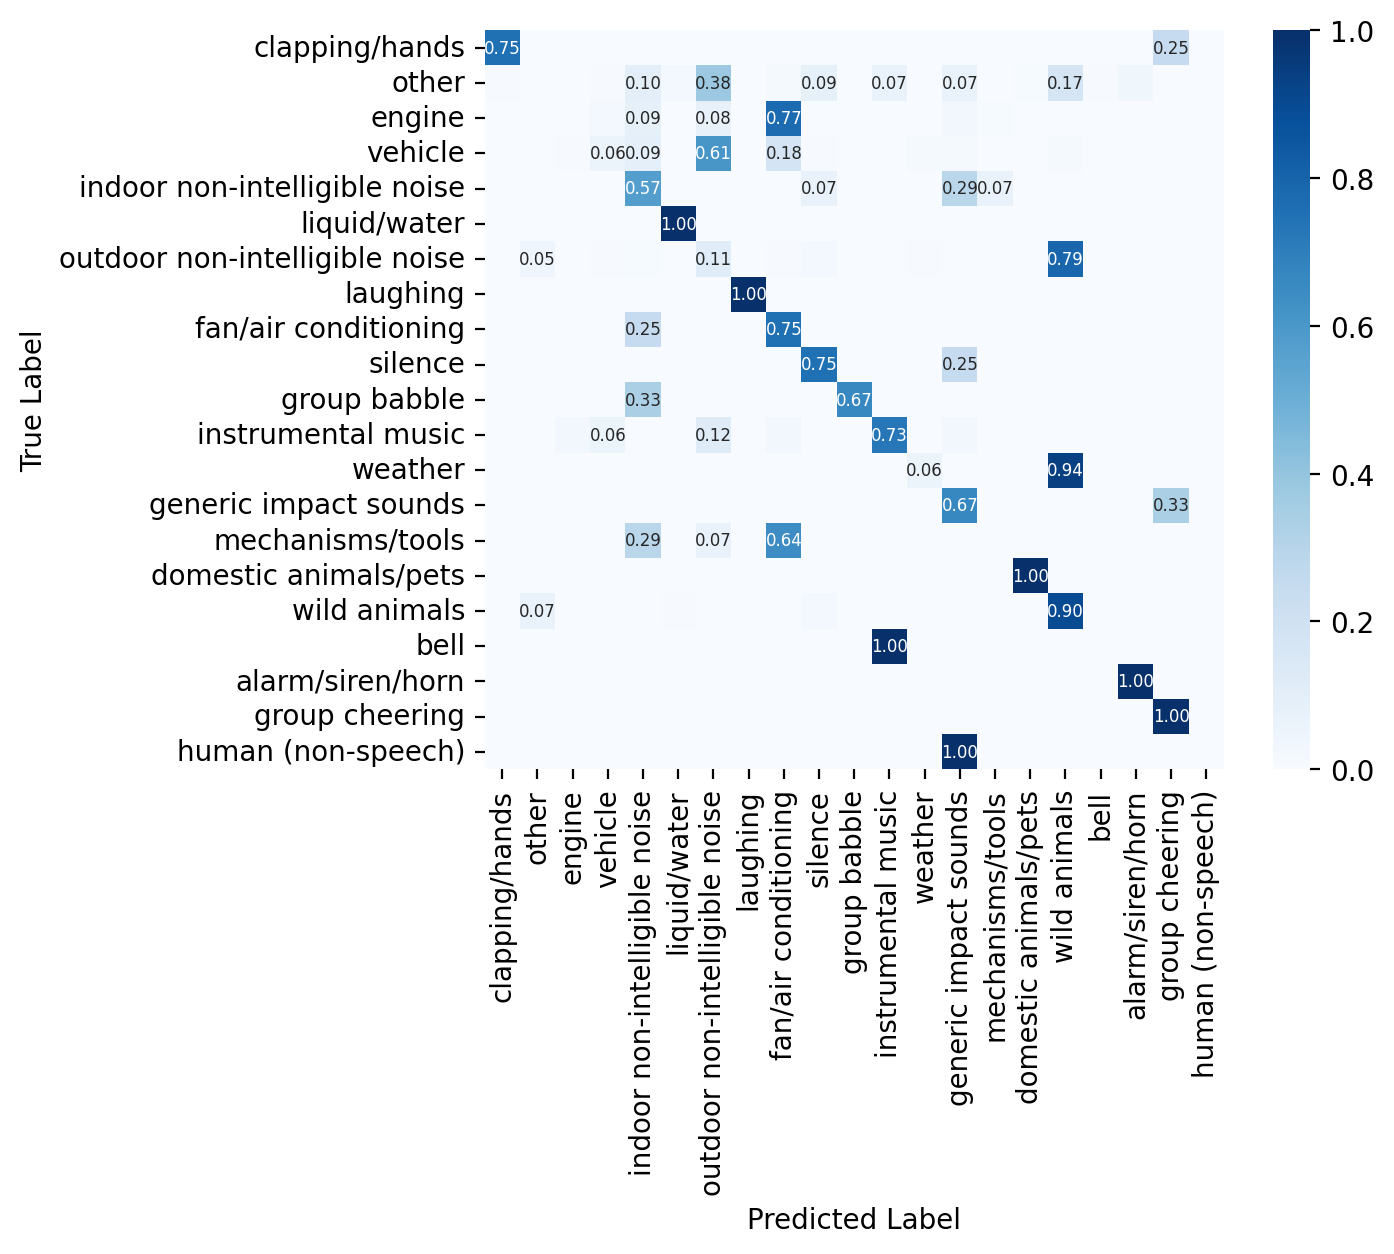

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# get confusion matrix
conf_matrix = confusion_matrix(y_label_val,y_pred_val)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
mean_recall = np.mean(recall_by_class)

# Calculate row sums to use for percentages
row_sums = conf_matrix.sum(axis=1)

# Calculate percentages
percentages = (conf_matrix.T / row_sums).T  # Transpose for division, then transpose back

# Format percentages as strings with '%' symbol
annot_data = [['{:.2f}'.format(val) for val in row] for row in percentages]
annot_data = [['' if float(val <= 0.04) else '{:.2f}'.format(val) for val in row] for row in percentages]

plt.figure(dpi=200)

annot_kws = {'size': 6}
ax = sns.heatmap(percentages, xticklabels=classes, yticklabels=classes, annot=annot_data, fmt='', square=True, cmap='Blues', annot_kws=annot_kws)
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('True Label')

#plt.subplots_adjust(left=0.2, bottom=0.35)
plt.show()